<a href="https://colab.research.google.com/github/paulxdillon/Chem-Eng/blob/master/AcetontrileWaterVLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## VLE for Acetonitrile Water mixure

Set up python imports

In [183]:
import matplotlib.pyplot as plt1 
import matplotlib.pyplot as plt2
import matplotlib.pyplot as plt3
# import matplotlib.pyplot as plt2
from matplotlib.lines import Line2D
from scipy.optimize import fsolve
from scipy.integrate import odeint
from scipy.integrate import ode
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np

Components = ['Acetonitrile', 'Water', 'N.A.']
Pairs = ['Acetonitrile/Water', 'Acetonitrile / N.A.', 'Water/N.A.']

TBub = [[],[],[]]
TDew = [[],[],[]]
gam1List = [[],[],[]]
gam2List = [[],[],[]]
gam3List = [[],[],[]]
Tguess = 85.0
y = [[],[],[]]




Define vapour-pressure of pure components (parameters from NIST databook):

In [184]:
Psat = dict()
Psat['Acetonitrile']       = lambda T: 10**(4.27873-(1355.374/(T-37.853)))
Psat['Water']       = lambda T: 10**(5.08354-(1664.125/(T-45.622)))
# Psat['N.A.']       = lambda T: np.exp(73.1511 +
#                                        (-8307.2)/(T + 0.0) +
#                                        0.0*(T) +
#                                        (-8.5767)*np.log(T) +
#                                        7.5091E-18*(T)**1.0 )

Psat['N.A.']       = lambda T: 1E-6

Define NRTL function, bubble point and dew-point functions
(Note:  this code can handle ternary mixtures; for binary mixtures, the 3rd component is ignored)

In [185]:
def nrtl(alpha, tau, T, x):
    tau[0, 0] = 0
    tau[0, 1] = a12 + b12 / ( T )
    tau[0, 2] = a13 + b13 / ( T )
    tau[1, 0] = a21 + b21 / ( T )
    tau[1, 1] = 0
    tau[1, 2] = a23 + b23 / ( T )
    tau[2, 0] = a31 + b31 / ( T )
    tau[2, 1] = a32 + b32 / ( T )
    tau[2, 2] = 0
    G = np.exp(-alpha * tau)
    ncomp = x.shape[0]
    gamma = np.zeros_like(x)

    for i in range(ncomp):
        summ = 0
        for j in range(ncomp):
            summ += x[j] * G[i, j] / np.sum(G[:, j] * x) * (
                        tau[i, j] - (np.sum(x * tau[:, j] * G[:, j]) / np.sum(G[:, j] * x)))
        gamma[i] = np.sum(tau[:, i] * G[:, i] * x) / np.sum(G[:, i] * x) + summ

    if np.isinf(gamma[0]):
        print("Gamm is finite ...")

    return np.exp(gamma)



def bubblePt(x, T, P):
    tau[0, 0] = 0
    tau[0, 1] = a12 + b12 / ( T )
    tau[0, 2] = a13 + b13 / ( T )
    tau[1, 0] = a21 + b21 / ( T )
    tau[1, 1] = 0
    tau[1, 2] = a23 + b23 / ( T )
    tau[2, 0] = a31 + b31 / ( T )
    tau[2, 1] = a32 + b32 / ( T )
    tau[2, 2] = 0
    [gam1, gam2, gam3] = nrtl(alpha, tau, T, np.asarray(x))
    if np.isnan(tau).any():
        print("Tau is NAN ...")

    f = P - x[0] * gam1 * Psat[Components[0]](T) - x[1] * gam2 * Psat[Components[1]](T) - x[2] * gam3 * Psat[Components[2]](T)
    return f

def dewPt(y, T, P):
    tau[0, 1] = a12 + b12 / (T + 273.15)
    tau[0, 2] = a13 + b13 / (T + 273.15)
    tau[1, 0] = a21 + b21 / (T + 273.15)
    tau[1, 2] = a23 + b23 / (T + 273.15)
    tau[2, 0] = a31 + b31 / (T + 273.15)
    tau[2, 1] = a32 + b32 / (T + 273.15)
    [gam1, gam2, gam3] = nrtl(alpha, tau, T, np.asarray(y))

    f = P - 1 / (y[0] / (gam1 * Psat[Components[0]](T)) + y[1] / (gam2 * Psat[Components[1]](T)) + y[2] / (
                gam3 * Psat[Components[2]](T)))
    return f



NRTL binary parameters (from literature source):

In [186]:
a12 = -0.1164
a21 = 1.0567
a13 = 0
a31 = 0
a23 = 0
a32 = 0

b12 = 256.459
b21 = 283.409

b13 = 0
b31 = 0

b23 = 0
b32 = 0

c12 = 0.3
c21 = 0.3
c13 = 0
c31 = 0
c23 = 0
c32 = 0

ncomp = 3
tau = np.ndarray((ncomp, ncomp), float)
alpha = np.ndarray((ncomp, ncomp), float)

alpha = np.ndarray((3, 3), float)

alpha[0, 0] = 0;     alpha[0, 1] = c12;     alpha[0, 2] = c13
alpha[1, 0] = c12;   alpha[1, 1] = 0;       alpha[1, 2] = c23
alpha[2, 0] = c13;   alpha[2, 1] = c23;     alpha[2, 2] = 0;

Plot Vapour pressure vs. composition (molefraction) using temperature as parameter (valid below the mixture bubble point curve)

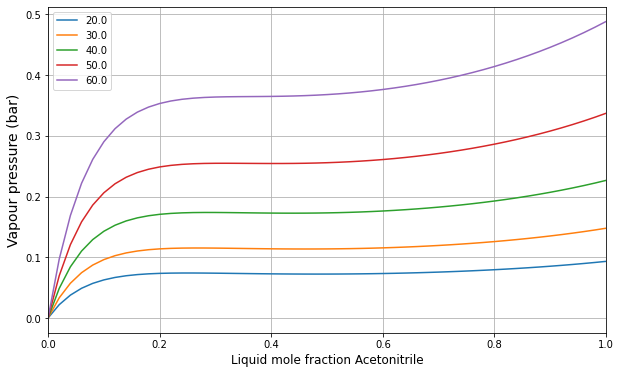

In [187]:
x = np.linspace(0, 1, 51).tolist()
TList = [20+273.15, 30+273.15, 40+273.15, 50+273.15, 60+273.15]
pvapList = []

plt3.figure(figsize=(10, 6))

for T in TList:
    pvapT = []
    for xFrac in x:
      [gam1, gam2, gam3] = nrtl(alpha, tau, T, np.asarray([xFrac, 1 - xFrac, 0]))

      pvapT.append(xFrac * gam1 * Psat[Components[0]](T))
      pvapList.append(pvapT)
    plt3.plot(x, pvapT)

plt3.xlabel('Liquid mole fraction ' + Components[0], fontsize=12)
plt3.ylabel('Vapour pressure (bar)', fontsize=14)
plt3.grid()
plt3.xlim(0, 1)
plt3.legend([round(T-273.15,1) for T in TList], fontsize=10)
plt3.show()

Plot Txy, activity coefficient and y-x plots for acetontrile-water mixture

In [188]:
plotTxy = 1

if plotTxy:
    x = np.linspace(0, 1, 51).tolist()
    Tguess = 320
    P = 1.01325
    # Pair 1-2
    for xFrac in x:
        Tbubble, = fsolve(lambda T: bubblePt([xFrac, 1 - xFrac, 0], T, P), Tguess, xtol=1e-12)
        Tdew, = fsolve(lambda T: dewPt([xFrac, 1 - xFrac, 0], T, P), Tguess, xtol=1e-12)
        TDew[0].append(Tdew)
        TBub[0].append(Tbubble)

        [gam1, gam2, gam3] = nrtl(alpha, tau, Tbubble, np.asarray([xFrac, 1 - xFrac, 0]))

        y1 = xFrac * gam1 * Psat[Components[0]](Tbubble) / P
        y[0].append(y1)

        gam1List[0].append(gam1)
        gam2List[0].append(gam2)


Plot Txy, activity coefficient and y-x plots for acetontrile-water mixture

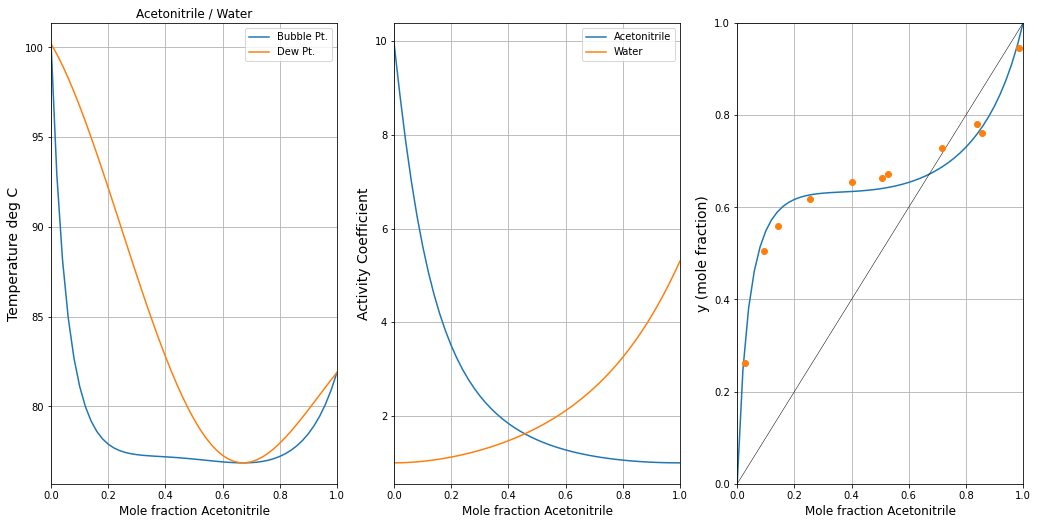

In [189]:
plt1.figure(figsize=(20, 8))

# Plot T-xy
# =========
plt1.subplot(1, 3, 1)
plt1.plot(x, [x - 273.15 for x in TBub[0]], x, [x - 273.15 for x in TDew[0]])
plt1.xlabel('Mole fraction ' + Components[0], fontsize=12)
plt1.ylabel('Temperature deg C', fontsize=14)
plt1.title(Components[0] + ' / ' + Components[1], fontsize=12)
plt1.legend(['Bubble Pt.', 'Dew Pt.'], fontsize=10)
plt1.grid()
plt1.xlim(0, 1)


# Plot Activity Coefficients (NRTL model)
# =======================================
plt1.subplot(1, 3, 2)
plt1.plot(x, gam1List[0], x, gam2List[0])
plt1.xlabel('Mole fraction ' + Components[0], fontsize=12)
plt1.ylabel('Activity Coefficient', fontsize=14)
# plt1.title( Components[0] + ' / ' + Components[1], fontsize=12 )
plt1.legend([Components[0], Components[1]], fontsize=10)
plt1.grid()
plt1.xlim(0, 1)

# Plot y vs x
# ============
plt1.subplot(1, 3, 3)
plt1.plot(x, y[0])
plt1.xlabel('Mole fraction ' + Components[0], fontsize=12)
plt1.ylabel('y (mole fraction)', fontsize=14)
plt1.grid()
plt1.xlim(0, 1)
plt1.ylim(0, 1)
plt1.yticks(np.linspace(0, 1.0, 6))
plt1.plot([1, 0, ], [1, 0], '-k', linewidth=.5)

TData = [359.65, 354.25, 353.15, 351.75, 350.55, 349.85, 349.75, 349.15, 349.75, 349.95, 353.55, ]
xData = [0.029, 0.093, 0.142, 0.254, 0.402, 0.507, 0.527, 0.718, 0.839, 0.856, 0.986]
yData = [0.263, 0.505, 0.559, 0.617, 0.655, 0.664, 0.673, 0.728, 0.78, 0.761, 0.945]
plt1.plot(xData, yData, '.',  markersize=12)

plt1.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
plt1.tight_layout
plt1.show()

Notes:
1. Left figure shows min-boiling azeotrope at a molefraction of around 0.7, T=75C (P=1 barA)
2. Reasonable agreement with experimental data in figure on right.